Below are python packages that we'll need assist us in analyzing our graph's degree distribution. 

In [183]:
import build_influence_network as bn
from distfit import distfit
import csv
import math
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import powerlaw
import seaborn as sns
import scipy.stats as st

In [5]:
# As a csv.reader is usuable once and only once we write the lines of our csv file to a list 
with open("influence_data.csv", "rt") as infile:
    reader = csv.reader(infile)
    next(reader)
    influence_data = list(reader)
    
# As a csv.reader is usuable once and only once we write the lines of our csv file to a list 
with open("data_by_artist.csv", "rt") as infile:
    reader = csv.reader(infile)
    next(reader)
    artist_data = list(reader)

In [182]:
graph = bn.build_graph(influence_data, artist_data)

Our graph is an acyclic directed graph: False
Our artistic influence network has 5603 artists.
Our artistic influence network has 42770 edges out of a possible 31388006 possible edges.
Our network density is: 0.0013626223978675167
Our graph is strongly connected False
The number of strongly connected components is 4747
The average clustering coefficient is 0.09128001728442253


Let's use seaborn's  <a href="https://seaborn.pydata.org/generated/seaborn.displot.html#seaborn.displot" title=”Distplot”>distplot</a> function to plot both the histogram of the degree distribution of our graph, which is represented as light blue bars, and the the kernal dentisty estimate (KDE) which is represented by a solid blue line. 

The number of bins we are using for our histogram is: 74


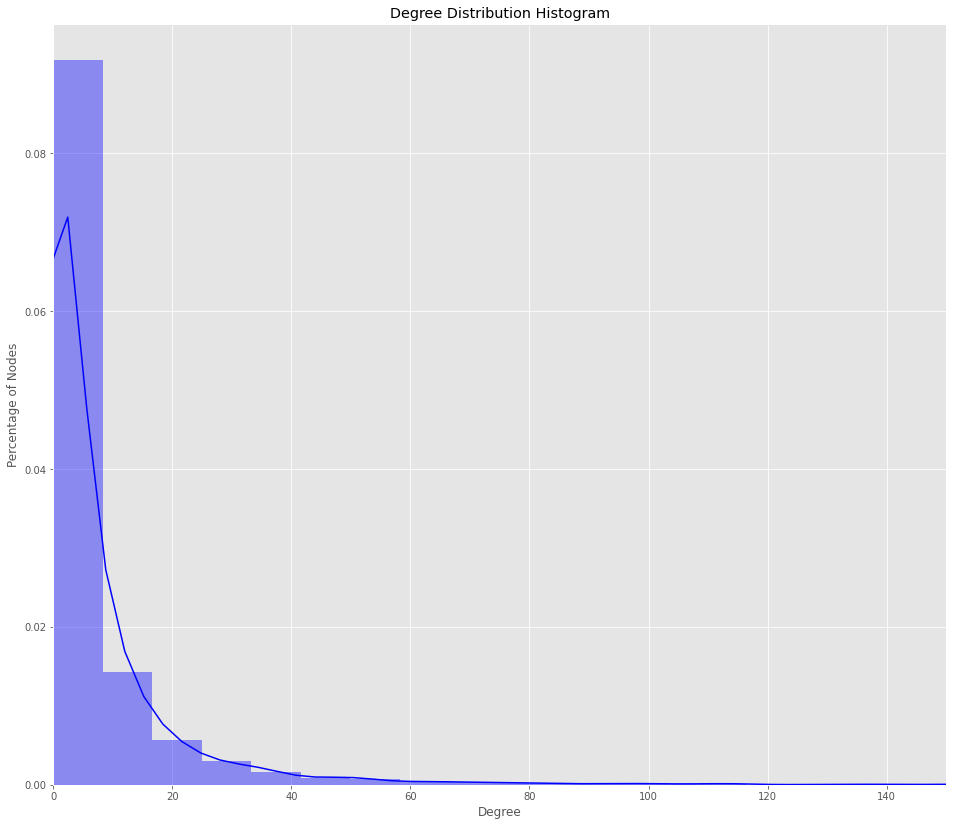

In [181]:
def plot_degree_dist(graph):
    """
    Plots a histograph of the in degree distribution of the nodes of a directed graph.
    Parameters
    ----------
    graph : a NetworkX directed graph 

    Notes
    -----
    """
    degrees = [graph.in_degree(n) for n in graph.nodes()]
    bin_num = math.sqrt(len(degrees))
    print("The number of bins we are using for our histogram is: " + str(int(bin_num)))
    #fig, ax = plt.subplots()
    sns.distplot(degrees, bins = int(bin_num), color = "b", kde= True)
    plt.xlim([0,150])
    plt.title("Degree Distribution Histogram")
    plt.ylabel("Percentage of Nodes")
    plt.xlabel("Degree")
    plt.show()

plot_degree_dist(graph)

Power laws are probability distributuons of the form \begin{equation} p(x) \propto x^{-\alpha} \end{equation}

<a href="https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0085777" title=”powerlaw_paper”>Alstott et. al. powerlaw: A Python Package for Analysis of Heavy-Tailed Distributions</a> and the associated python package <a href="https://github.com/jeffalstott/powerlaw" title=”powerlaw_github”>powerlaw</a> based on <a href="https://arxiv.org/abs/0706.1062" title=”clauset”>Clauset et. al. Power-law distributions in empirical data</a>

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Assuming nested distributions


Our alpha is: 2.7153506422325275
Our standard error, sigma, is: 0.08788007555347738
----------------------------------------------------------------------------------------------
Power law compared with lognormal: (-1.3800224715833833, 0.3139509935226249)
Power law compared with exponential: (40.66105530901663, 0.008631217956483306)
Power law compared with lognormal positive: (-1.315819712033119, 0.43806014779742586)
Power law compared with stretched exponential: (-1.476805738925889, 0.36557860921379937)
Power law compard with truncated power law: (-1.8816193169266402, 0.052391009976793246)
----------------------------------------------------------------------------------------------


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Assuming nested distributions


(-2.929564269390303, 0.015496464749170324)


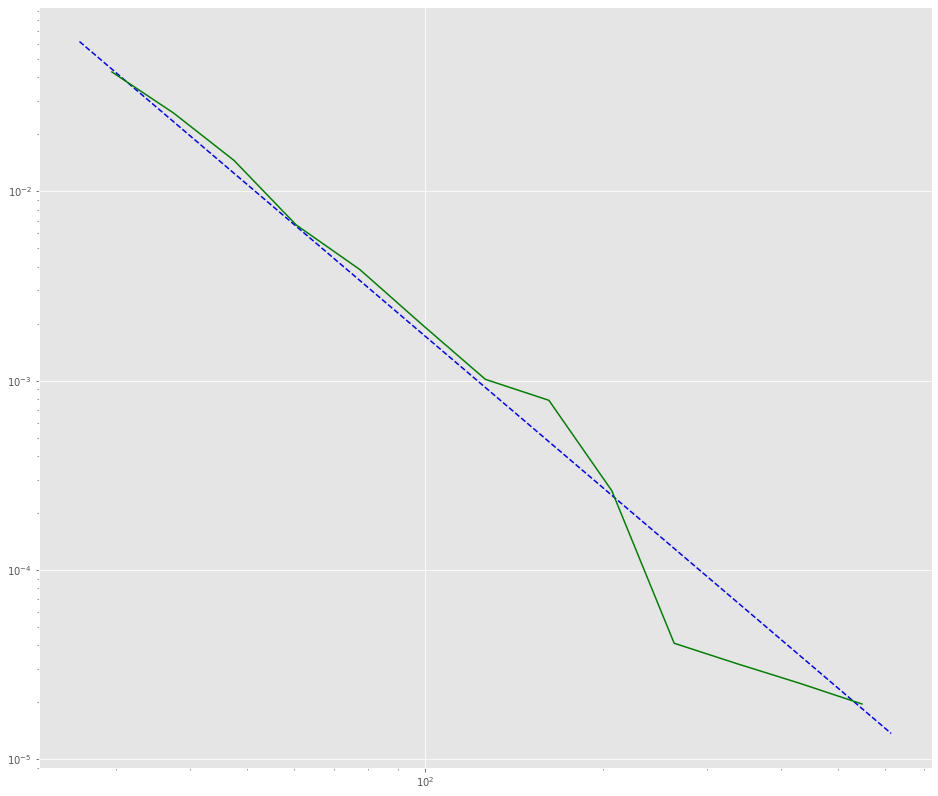

In [210]:
def plot_power_law(graph):
    """ 
    Compare a power law distribution of node in-degrees to lognormal, exponential, lognormal positive, stretched exponential, and truncated power law       

    Parameters
    ----------
    graph : a NetworkX directed graph
        
    Notes
    -----
    See comment by Aaron Clauset in the thread:
    https://stackoverflow.com/questions/49266070/comparing-power-law-with-other-distributions

    """
    data = [graph.in_degree(n) for n in graph.nodes()]
    fit = powerlaw.Fit(data)
    print("Our alpha is: " + str(fit.power_law.alpha))
    print("Our standard error, sigma, is: " + str(fit.power_law.sigma))
    print("----------------------------------------------------------------------------------------------")
    print("Power law compared with lognormal: " + str(fit.distribution_compare('power_law', 'lognormal')))
    print("Power law compared with exponential: " + str(fit.distribution_compare('power_law', 'exponential')))
    print("Power law compared with lognormal positive: " + str(fit.distribution_compare('power_law', 'lognormal_positive')))
    print("Power law compared with stretched exponential: " + str(fit.distribution_compare('power_law', 'stretched_exponential')))
    print("Power law compard with truncated power law: " + str(fit.distribution_compare('power_law', 'truncated_power_law')))
    print("----------------------------------------------------------------------------------------------")

    #print(results.power_law.alpha)
    #print(results.power_law.xmin)
    #print(np.isfinite(data).all())
    #figPDF = powerlaw.plot_pdf(np.array(data), color='b')
    #powerlaw.plot_pdf(np.array(data), linear_bins=True, color='r', ax=figPDF)
    #np.seterr(divide='ignore', invalid='ignore')
    fit=powerlaw.Fit(np.array(data), discrete=True)
    #print(fit.power_law.alpha)
    print(fit.distribution_compare('power_law', 'truncated_power_law'))
    fit.power_law.plot_pdf( color= 'b',linestyle='--',label='fit ccdf')
    # Linear bins?
    #fit.plot_pdf(color= 'r', linear_bins=True)
    # Logarithmic bins?
    fit.plot_pdf(color = 'g')
    plt.show()
    
plot_power_law(graph)

What is this telling us? 

When comparing the power law fit with other distributions the powerlaw package is performing a likelihood ratio test (LRT) and producting a pair of numbers
R: the normalized log likelihood ratio
p: the statistical significance of R

To quote Aaron Clauset's comment (which is linked in plot_power_law's comments) regarding the output:
"The thing that is being tested for the p-value here is whether the sign of R is meaningful. If p < 0.05 for a LRT, then a positive sign indicated the power-law model is favored."

In [165]:
from scipy.stats import nbinom, poisson, geom, hypergeom

degrees = pd.Series([graph.in_degree(n) for n in graph.nodes()])
mean = degrees.mean()
var = degrees.var()
likelihoods = {}  # we'll use it later

# From the wikipedia page, we have:
# mean = pr / (1-p)
# var = pr / (1-p)**2
# without wiki, you could use MGF to get moments; too long to explain here
# Solving for p and r, we get:

p = mean / var
r = p * mean / (1-p)

likelihoods['nbinom'] = degrees.map(lambda val: nbinom.pmf(val, r, p)).prod()

# from Wikipedia,
# mean = variance = lambda. Nothing to solve here
lambda_ = mean
likelihoods['poisson'] = degrees.map(lambda val: poisson.pmf(val, lambda_)).prod()

# from Wikipedia,
# mean = variance = lambda. Nothing to solve here
lambda_ = mean
likelihoods['poisson'] = degrees.map(lambda val: poisson.pmf(val, lambda_)).prod()

# mean = 1 / p  # this form fits the scipy definition
p = 1 / mean

likelihoods['geometric'] = degrees.map(lambda val: geom.pmf(val, p)).prod()

best_fit = max(likelihoods, key=lambda degrees: likelihoods[degrees])
print(likelihoods)
print("Best fit:", best_fit)
print("Likelihood:", likelihoods[best_fit])

{'nbinom': 0.0, 'poisson': 0.0, 'geometric': 0.0}
Best fit: nbinom
Likelihood: 0.0


[distfit] >fit..
[distfit] >transform..
[smoothline] >Smoothing by interpolation..
[distfit] >[norm      ] [0.01 sec] [RSS: 0.0002596] [loc=11.333 scale=22.726]
[distfit] >[expon     ] [0.00 sec] [RSS: 0.0023039] [loc=1.000 scale=10.333]
[distfit] >[pareto    ] [0.08 sec] [RSS: 0.0008097] [loc=-1.249 scale=2.249]
[distfit] >[dweibull  ] [0.08 sec] [RSS: 0.0007353] [loc=3.000 scale=7.051]
[distfit] >[t         ] [0.05 sec] [RSS: 0.0023758] [loc=4.108 scale=3.709]
[distfit] >[genextreme] [0.38 sec] [RSS: 0.0002972] [loc=1.000 scale=0.001]
[distfit] >[gamma     ] [0.07 sec] [RSS: 0.0003809] [loc=1.000 scale=1.568]
[distfit] >[lognorm   ] [0.19 sec] [RSS: 0.0002278] [loc=1.000 scale=0.568]
[distfit] >[beta      ] [0.15 sec] [RSS: 0.0002261] [loc=1.000 scale=1122.400]
[distfit] >[uniform   ] [0.00 sec] [RSS: 0.0003470] [loc=1.000 scale=614.000]
[distfit] >[loggamma  ] [0.12 sec] [RSS: 0.0001810] [loc=-10072.764 scale=1288.114]
[distfit] >Compute confidence interval [parametric]
------------

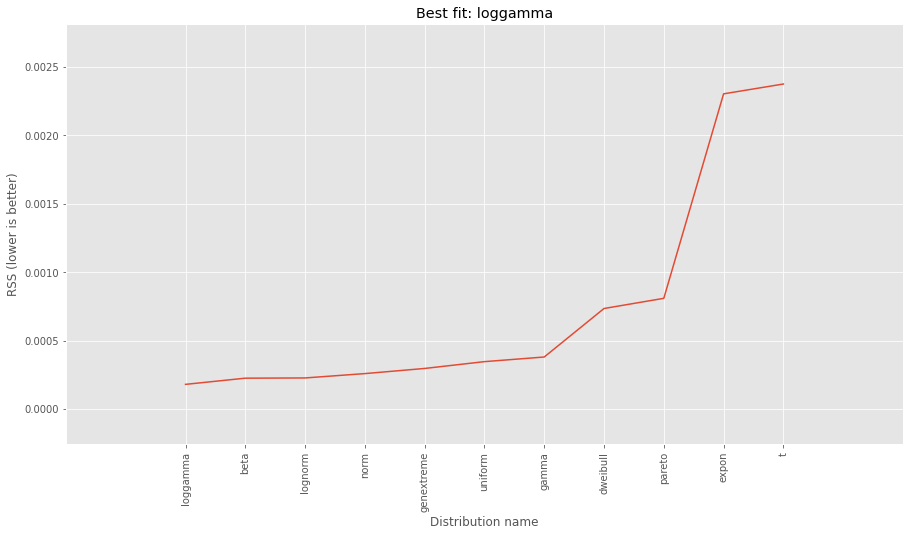

(<Figure size 1080x576 with 1 Axes>,
 <AxesSubplot:title={'center':'Best fit: loggamma'}, xlabel='Distribution name', ylabel='RSS (lower is better)'>)

In [184]:
# Taken from:
# https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python/62339711#62339711
degrees = np.array([graph.in_degree(n) for n in graph.nodes() if graph.in_degree(n) > 0])

dist = distfit(alpha=0.05, smooth=10)

dist.fit_transform(degrees)

# Best fitted model
best_distr = dist.model
print("----------------")
print(best_distr)

# Ranking distributions
dist.summary

# Plot the summary of fitted distributions
dist.plot_summary()